# Attempts to Classify Basketball Player Positions based on Player Data and Season Stats

In [1]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier

<center><mark>[NOTE] You must run the PreProcessing Notebook to prepare the data</mark></center>

## Based on Player Data

In [2]:
player_data = pd.read_csv("./data/player_data.csv")
player_data.head()


,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,"April 7, 1946",Iowa State University
2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225.0,"April 16, 1947","University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University


In [3]:
print(player_data.shape)

(4550, 8)


Prior to using any classification methods, we must first examine the data to determine whether there are invalid/malformed data points or missing values in our dataset:

In [4]:
print(f"Players with NaN for height {player_data['height'].isnull().sum()}")
print(f"Players with NaN for weight {player_data['weight'].isnull().sum()}")

Players with NaN for height 1
Players with NaN for weight 6


We can see that there are 7 entries with `NaN`s. Since this number is minute, compared to the entire dataset, we will disregard them.

In [5]:
player_data.dropna(inplace=True)

Also, since most classifiers like their input features to be nice and numerical, we will modify the `height` attribute to be in inches (currently in `ft-in` form).

In [6]:
def height_to_inches(height):
    feet, inches = map(int, height.split("-"))
    return feet * 12 + inches


# Apply the function to the DataFrame
player_data["height_inches"] = player_data["height"].apply(height_to_inches)
player_data.head(1)

,name,year_start,year_end,position,height,weight,birth_date,college,height_inches
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University,82


As a start, let's just use height and weight to predict player position.

In [7]:
X = player_data[["weight", "height_inches"]]
y = player_data["position"]
le = LabelEncoder()
y = le.fit_transform(y)  # Encode categorical variables into numerical labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

We begin by using a Random Forest Classifier

In [8]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 59.19335705812574%


---

## Based on Season Stats

In [10]:
season_data = pd.read_csv("./data/Seasons_Stats.csv")
season_data.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


Note that this value has many `NaN`s (null values), especially from older data. So we need to do pre-processing to remove those entries.

In [11]:
# Clean Data by dropping columns with all NaN values
season_data.drop(['Unnamed: 0', 'blanl', 'blank2'], axis=1, inplace=True, errors="ignore")

# Add height and weight to players
season_data['height_inches'] = np.nan
season_data['weight'] = np.nan
season_data['bmi'] = np.nan
for index, row in player_data.iterrows():
    season_data.loc[season_data['Player'] == row['name'], 'height_inches'] = row['height_inches']
    season_data.loc[season_data['Player'] == row['name'], 'weight'] = row['weight']
    season_data.loc[season_data['Player'] == row['name'], 'bmi'] = (703 * row['weight']) / (row['height_inches'] * row['height_inches'])

# Drop records with missing data
season_data.dropna(inplace=True)

# Also dropping the name of the player...hopefully players aren't assigned positions based on their names
# Also dropping the year since we are not predicting the position of a player in a specific year
season_data.drop(['Year', 'Player'], axis=1, inplace=True, errors="ignore")
season_data.head(5)

,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,...,TRB,AST,STL,BLK,TOV,PF,PTS,height_inches,weight,bmi
5781,SF,29.0,BOS,82.0,7.0,1994.0,14.6,0.526,0.054,0.316,...,330.0,156.0,120.0,36.0,143.0,214.0,914.0,78.0,205.0,23.687541
5786,SG,33.0,BOS,60.0,0.0,523.0,7.8,0.402,0.032,0.222,...,73.0,38.0,31.0,11.0,33.0,80.0,167.0,77.0,210.0,24.899646
5835,SG,31.0,BOS,73.0,73.0,2115.0,13.0,0.537,0.231,0.161,...,181.0,215.0,111.0,27.0,105.0,178.0,816.0,77.0,190.0,22.528251
5867,PG,24.0,BOS,76.0,2.0,1061.0,12.7,0.539,0.016,0.338,...,83.0,147.0,45.0,15.0,109.0,96.0,473.0,77.0,215.0,25.492495
5901,SF,23.0,BOS,65.0,0.0,674.0,14.1,0.567,0.098,0.275,...,66.0,47.0,29.0,5.0,49.0,91.0,351.0,78.0,185.0,21.376561


## XGBoost

In [12]:
y = season_data['Pos']
y = le.fit_transform(y)
X = season_data.drop('Pos', axis=1)
X['Tm'] = le.fit_transform(X['Tm']) # Encode team names as numerical labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='multi:softmax')
bst.fit(X_train, y_train)
preds = bst.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 46.37910565888405%


**XGBoost is worthless here!**

## Random Forest

In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [14]:
preds = rf.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 77.8393351800554%


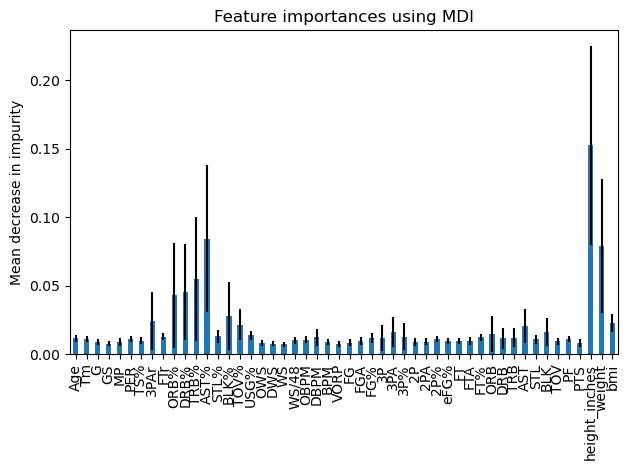

In [15]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=list(X.columns))
fig, ax = plt.subplots()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
forest_importances.plot.bar(yerr=std, ax=ax)
fig.tight_layout()

In [16]:
print(forest_importances.sort_values(ascending=False).head(10))

height_inches    0.152497
AST%             0.084540
weight           0.079285
TRB%             0.054946
DRB%             0.045327
ORB%             0.043157
BLK%             0.027941
3PAr             0.024496
bmi              0.023033
TOV%             0.021629
dtype: float64


In [17]:
import json
forest_importances
with open("feature_importances.json", "w") as f:
    json.dump(forest_importances.to_dict(), f)

### RandomForest Round 2: Only with five most important features

In [18]:
y = season_data['Pos']
y = le.fit_transform(y)
X = season_data[['AST%', 'TRB%', 'DRB%', 'ORB%', 'BLK%']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5947764147210131


## Decision Trees


In [19]:
y = season_data['Pos']
y = le.fit_transform(y)
X = season_data.drop('Pos', axis=1)
X['Tm'] = le.fit_transform(X['Tm']) # Encode team names as numerical labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [20]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

In [21]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6869806094182825


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.185455 to fit



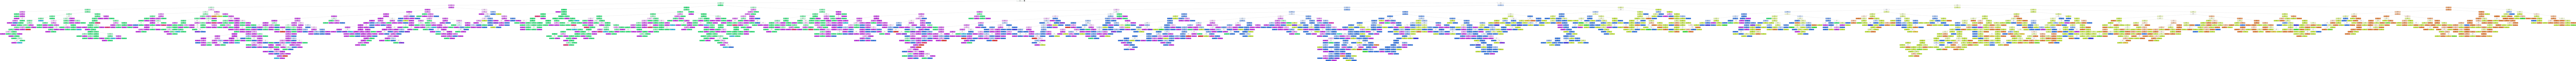

In [22]:
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('dtree.png')
Image(graph.create_png())

In [23]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(
    "Number of mislabeled points out of a total %d points : %d"
    % (X_test.shape[0], (y_test != y_pred).sum())
)

Number of mislabeled points out of a total 2527 points : 1008


---

## Combined Dataset: Season Stats + Player Data

In [24]:
combined_data = pd.read_csv("./data/season_stats_preprocessed.csv")
combined_data.head(1)

,Unnamed: 0,Index,Year,Player,Pos,Age,Tm,G,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height_inches,weight
0,5781,5781,1980.0,M.L. Carr,SF,29.0,BOS,82.0,7.0,1994.0,...,224.0,330.0,156.0,120.0,36.0,143.0,214.0,914.0,78.0,205.0


In [25]:
player_data = pd.read_csv("./data/player_data.csv")
player_data.dropna(inplace=True)

player_data["height_inches"] = player_data["height"].apply(height_to_inches)
player_data.head(1)

,name,year_start,year_end,position,height,weight,birth_date,college,height_inches
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University,82


In [26]:
print(combined_data.shape)

(12780, 54)


In [27]:
# Clean Data by dropping columns with all NaN values
# combined_data.drop(["Unnamed: 0", "blanl", "blank2"], axis=1)

# Add height and weight to players
combined_data["height_inches"] = np.nan
combined_data["weight"] = np.nan
combined_data["bmi"] = np.nan
for index, row in player_data.iterrows():
    combined_data.loc[combined_data["Player"] == row["name"], "height_inches"] = row[
        "height_inches"
    ]
    combined_data.loc[combined_data["Player"] == row["name"], "weight"] = row["weight"]
    combined_data.loc[combined_data["Player"] == row["name"], "bmi"] = (
        703 * row["weight"]
    ) / (row["height_inches"] * row["height_inches"])

# Drop records with missing data
combined_data.dropna(inplace=True)

# Also dropping the name of the player...hopefully players aren't assigned positions based on their names
# Also dropping the year since we are not predicting the position of a player in a specific year
combined_data.drop(["Year", "Player"], axis=1, inplace=True)
combined_data.head(5)

,Unnamed: 0,Index,Pos,Age,Tm,G,GS,MP,PER,TS%,...,TRB,AST,STL,BLK,TOV,PF,PTS,height_inches,weight,bmi
0,5781,5781,SF,29.0,BOS,82.0,7.0,1994.0,14.6,0.526,...,330.0,156.0,120.0,36.0,143.0,214.0,914.0,78.0,205.0,23.687541
1,5786,5786,SG,33.0,BOS,60.0,0.0,523.0,7.8,0.402,...,73.0,38.0,31.0,11.0,33.0,80.0,167.0,77.0,210.0,24.899646
2,5835,5835,SG,31.0,BOS,73.0,73.0,2115.0,13.0,0.537,...,181.0,215.0,111.0,27.0,105.0,178.0,816.0,77.0,190.0,22.528251
3,5867,5867,PG,24.0,BOS,76.0,2.0,1061.0,12.7,0.539,...,83.0,147.0,45.0,15.0,109.0,96.0,473.0,77.0,215.0,25.492495
4,5901,5901,SF,23.0,BOS,65.0,0.0,674.0,14.1,0.567,...,66.0,47.0,29.0,5.0,49.0,91.0,351.0,78.0,185.0,21.376561


In [28]:
le = LabelEncoder()
y = combined_data["Pos"]
X = combined_data.drop("Pos", axis=1)
X["Tm"] = le.fit_transform(X["Tm"])  # Encode team names as numerical labels
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=43
)
bst = XGBClassifier(
    n_estimators=2, max_depth=2, learning_rate=1, objective="multi:softmax"
)
bst.fit(X_train, y_train)
preds = bst.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 70.77464788732394%


In [29]:
rf = RandomForestClassifier(n_estimators=100, random_state=50)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=50)

In [30]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy-")
print(str(accuracy * 100) + "%")

print("\nSummary Statistics-")
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

Accuracy-
78.44287949921753%

Summary Statistics-


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.829545,0.732394,0.885370,0.715342,0.758037,0.784429,0.784138,0.785751
recall,0.688679,0.761506,0.908669,0.754386,0.745424,0.784429,0.771733,0.784429
f1-score,0.752577,0.746667,0.896868,0.734345,0.751678,0.784429,0.776427,0.784069
support,318.000000,478.000000,646.000000,513.000000,601.000000,0.784429,2556.000000,2556.000000


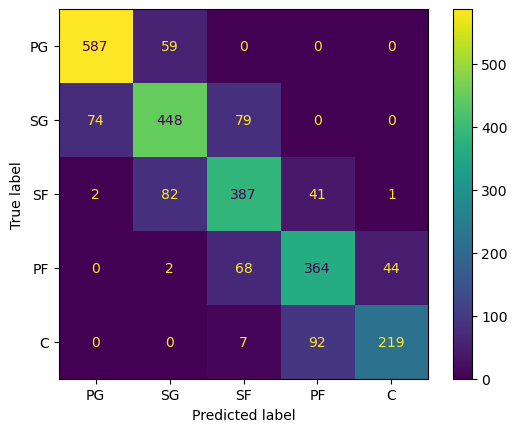

In [31]:
y_test = le.inverse_transform(y_test)
y_pred = le.inverse_transform(y_pred)

displ = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred, labels=["PG", "SG", "SF", "PF", "C"]),
    display_labels=["PG", "SG", "SF", "PF", "C"],
)
displ.plot()

In [32]:
y = season_data['Pos']
y = le.fit_transform(y)
X = season_data[['height_inches', 'AST%', 'weight', 'TRB%', 'DRB%', 'ORB%', 'BLK%', '3PAr', 'bmi', 'TOV%']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7874950534230313


Accuracy-
68.26276216857934%

Summary Statistics-


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


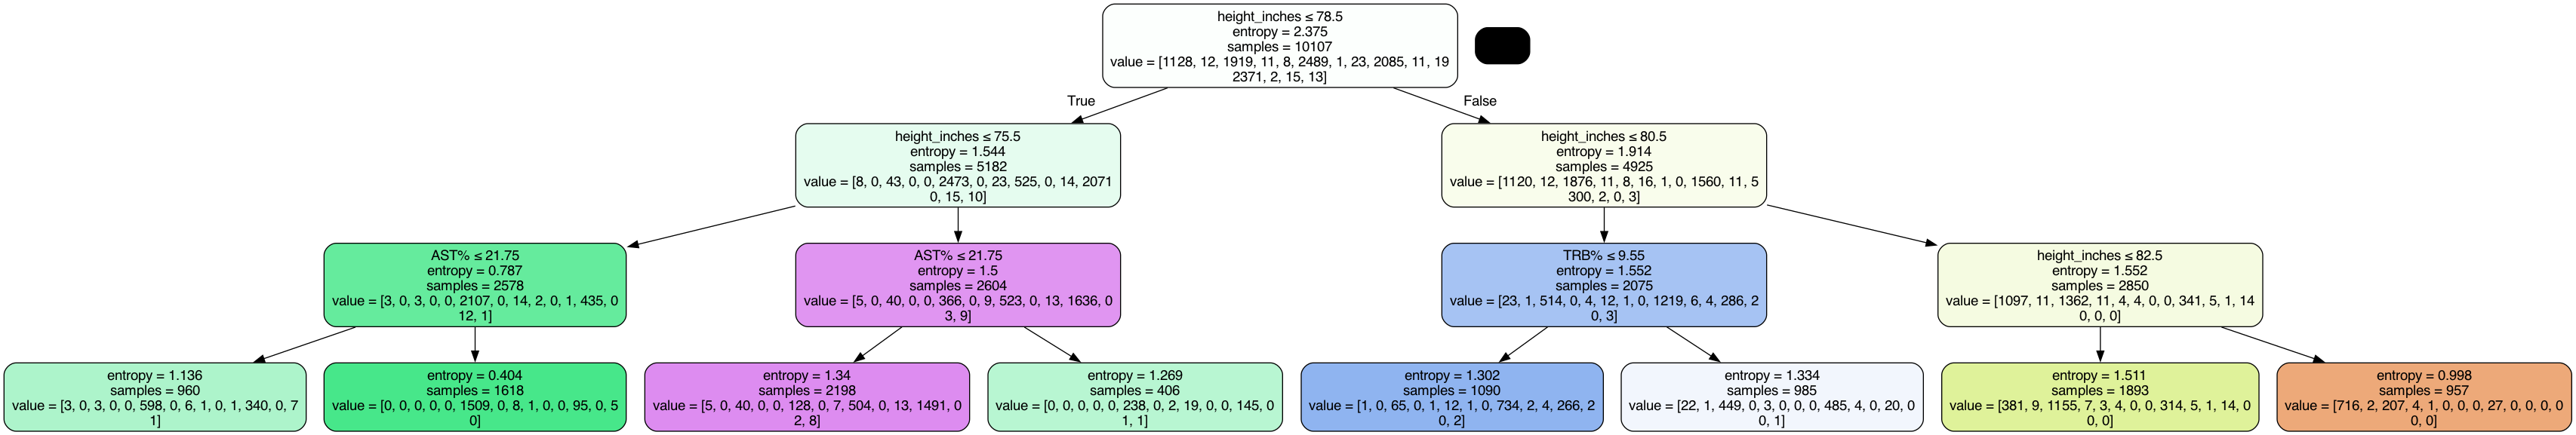

In [33]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

# criterion="entropy", max_depth=5
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy-")
print(str(accuracy * 100) + "%")

print("\nSummary Statistics-")
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))


dot_data = StringIO()
export_graphviz(
    clf,
    out_file=dot_data,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=list(X_train.columns),
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_png("dtree-min.png")
Image(graph.create_png())

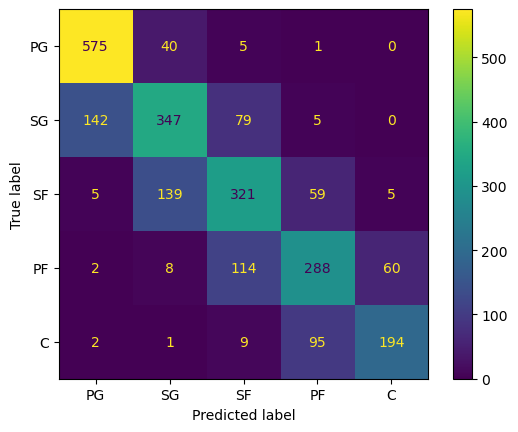

In [34]:
y_test = le.inverse_transform(y_test)
y_pred = le.inverse_transform(y_pred)

displ = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred, labels=["PG", "SG", "SF", "PF", "C"]),
    display_labels=["PG", "SG", "SF", "PF", "C"],
)
displ.plot()